#Preprocessing

In [1]:
import pandas as pd
df=pd.read_csv('/content/hcvdat0 (1).csv')

In [2]:
df=df.dropna()

In [3]:
df=df.sample(frac=1)
df

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
37,38,0=Blood Donor,35,m,48.7,72.7,24.1,31.0,45.1,9.40,3.80,90.0,20.0,75.8
351,352,0=Blood Donor,35,f,44.7,83.2,25.3,22.6,3.9,8.02,5.73,68.0,10.8,76.4
373,374,0=Blood Donor,41,f,42.4,51.3,16.3,18.3,4.0,6.68,4.24,65.0,17.1,71.9
31,32,0=Blood Donor,34,m,46.1,70.6,35.8,30.0,7.6,7.70,4.20,93.0,14.3,78.7
190,191,0=Blood Donor,49,m,44.4,63.3,13.5,16.4,7.3,11.19,4.49,73.0,13.6,72.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,611,3=Cirrhosis,62,f,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
260,261,0=Blood Donor,57,m,43.5,56.2,60.4,37.3,7.3,6.79,5.99,110.0,185.2,71.8
184,185,0=Blood Donor,48,m,46.4,64.1,29.3,27.6,13.2,10.07,8.28,98.0,28.9,83.3
7,8,0=Blood Donor,32,m,42.2,41.9,35.8,31.1,16.1,5.82,4.60,109.0,21.5,67.1


In [4]:
def normalize(df):
    result = df.copy()
    for feature_name in ['Age','ALB','ALP','ALT','AST','BIL','CHE','CHOL',"CREA","GGT",'PROT']:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [5]:
df['label']=[item[:2].replace("=","") for item in df['Category']]
df['Sex']=[0 if item=="f" else 1 for item in df['Sex']]
df=normalize(df)
df

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,label
37,38,0=Blood Donor,0.222222,1,0.502229,0.151493,0.071517,0.065093,0.212776,0.532355,0.287621,0.076557,0.023979,0.743405,0
351,352,0=Blood Donor,0.222222,0,0.442793,0.177399,0.075216,0.038290,0.014890,0.440294,0.521845,0.056017,0.009746,0.757794,0
373,374,0=Blood Donor,0.333333,0,0.408618,0.098692,0.047472,0.024569,0.015370,0.350901,0.341019,0.053216,0.019493,0.649880,0
31,32,0=Blood Donor,0.203704,1,0.463596,0.146311,0.107583,0.061902,0.032661,0.418946,0.336165,0.079358,0.015161,0.812950,0
190,191,0=Blood Donor,0.481481,1,0.438336,0.128300,0.038841,0.018507,0.031220,0.651768,0.371359,0.060685,0.014078,0.659472,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,611,3=Cirrhosis,0.722222,0,0.254086,1.000000,0.015413,0.318124,0.236311,0.276851,0.591019,0.044534,1.000000,0.568345,3
260,261,0=Blood Donor,0.629630,1,0.424963,0.110782,0.183416,0.085195,0.031220,0.358239,0.553398,0.095229,0.279548,0.647482,0
184,185,0=Blood Donor,0.462963,1,0.468053,0.130274,0.087546,0.054244,0.059558,0.577051,0.831311,0.084026,0.037748,0.923261,0
7,8,0=Blood Donor,0.166667,1,0.405646,0.075500,0.107583,0.065412,0.073487,0.293529,0.384709,0.094296,0.026300,0.534772,0


#Split 80% train 20% test

In [6]:
x_train=df.iloc[:468,2:-1]
# x_train

In [7]:
x_test=df.iloc[468:,2:-1]

In [8]:
y_train=df.iloc[:468,-1:]

In [9]:
y_test=df.iloc[468:,-1:]

#Transitive Closure

In [10]:
def transitive(R):
  r_o_r = []
  for row in R:
    RT_row = []
    for column in R:
        temp = []
        for x1, x2 in zip(row, column):
            temp.append(min(x1, x2))
        RT_row.append(max(temp))
    r_o_r.append(RT_row)
  RT = np.maximum(R, np.array(r_o_r))
  return RT

#Distance

In [11]:
from math import sqrt
import numpy as np
def dist(df):
  dist=[]
  index=0
  for item1 in df.itertuples():
    dist.append([])
    item1=np.array(item1[1:])
    for item2 in df.itertuples():
      item2=np.array(item2[1:])
      sum=0
      for i in range(0,len(item2)) :
        sum+=(item1[i]-item2[i])**2
      dist[index].append(sqrt(sum))
    index+=1
  normal_dist=dist/np.max(dist)- np.min(dist)
  return normal_dist

#Similarity class

In [12]:
def similar_class(matrix,alpha):
    mat=matrix.copy()
    mat=transitive(mat)
    m,n=np.shape(mat)
    for i in range(0,m):
        for j in range(0,n):
            if mat[i][j]<alpha:
                mat[i][j]=1 #small distances are similar
            else:
                mat[i][j]=0
    return mat


#detect neighbors

In [13]:
def get_neighbors(y):
    label=np.array(y)
    label=label.reshape(len(label))
    res=[]
    index=0
    for item in label:
        res.append([])
        for item2 in label:
            if(item==item2):
                res[index].append(1)
            else:
                res[index].append(0)
        index+=1
    return res

#find optimum alpha

In [14]:
train_dis=dist(x_train)
test_dis=dist(x_test)

In [15]:
neighbor_train=get_neighbors(y_train)
neighbor_test=get_neighbors(y_test)

In [16]:
def xfrange(start, stop, step):
    i = 0
    while start + i * step < stop:
        yield start + i * step
        i += 1

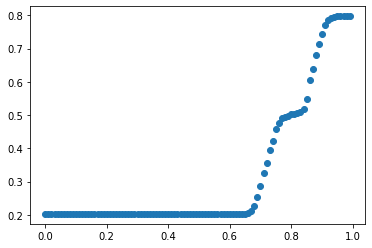

In [17]:
import matplotlib.pyplot as plt
acc=[]
for alpha in xfrange(0,1,0.01):
    similar_train=similar_class(train_dis,alpha)
    acc.append((alpha,np.mean(neighbor_train==similar_train)))
plt.scatter([item[0] for item in acc],[item[1] for item in acc])
def sort_key(e):
    return e[1]
acc.sort(key=sort_key)
acc.reverse()

#print accuracy

In [18]:
print(acc[1])

(0.97, 0.7974285923003872)


In [19]:
similar_test=similar_class(test_dis,acc[1][0])
np.mean(neighbor_test==similar_test)

0.8151765589782118